In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.layers import Dense, LSTM, Attention, Input

In [57]:
SEED = 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# # Call the above function with seed value
set_global_determinism(seed=SEED)

In [58]:
# tf.random.set_seed(0)
layers = (32,32)
function = 'elu'
saidaFunction = 'elu'
batch = 32
learningRate = 0.001
epocas = 1000
iterNochange = 10

In [59]:
# Importando os dados de energia
Data = pd.read_csv("dados_diarios_14Nov_outliers.csv")
Data.columns = Data.columns.str.strip()
Data_Power = Data["Daily Power yields (kWh)"].dropna()
Data_Power_desn = Data_Power

scaler = MinMaxScaler()
data = Data_Power.values
data = data.reshape(-1, 1)
normalized_data = scaler.fit_transform(data)
Data_Power = pd.Series(
    [value for row in normalized_data for value in row], name="Daily Power yields (kWh)"
)


Data_Power.head()

0    0.174908
1    0.343454
2    0.567474
3    0.557986
4    0.199353
Name: Daily Power yields (kWh), dtype: float64

In [60]:
Data_Power_train = Data_Power[:-6]

In [61]:
X = pd.concat([Data_Power_train.shift(1), Data_Power_train.shift(2), Data_Power_train.shift(3),], axis=1)
y = pd.concat([Data_Power_train.shift(-3)], axis=1)
X.dropna(inplace=True)
y.dropna(subset=["Daily Power yields (kWh)"], inplace=True)
print(X.shape)
print(y.shape)
X = X.to_numpy()
y = y.to_numpy()
y = y.flatten()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, shuffle=False, stratify=None
)

(115, 3)
(115, 1)


In [62]:
model = tf.keras.models.load_model('modelo_australia.h5')
model.trainable = False
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1217 (4.75 KB)
_________________________________________________________________
None


In [63]:
for layer in model.layers:
    layer.trainable = False

In [64]:
base_inputs = model.layers[0].input
base_outputs = model.layers[-2].output

output = Dense(1, name='output')(base_outputs)
new_model = tf.keras.Model(inputs=base_inputs, outputs=output)
new_model.summary()


for layer in new_model.layers:
    print("weights:", len(layer.weights))
    print("trainable_weights:", len(layer.trainable_weights))
    print("non_trainable_weights:", len(layer.non_trainable_weights))



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 1184 (4.62 KB)
_________________________________________________________________
weights: 0
trainable_weights: 0
non_trainable_weights: 0
weights: 2
trainable_weights: 0
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_traina

In [65]:
y_train = np.array(y_train).astype('float32')

Epoch 1/20


3/3 [==============================] - 0s 49ms/step - loss: 0.1608 - val_loss: 0.1717
Epoch 2/20
3/3 [==============================] - 0s 10ms/step - loss: 0.1501 - val_loss: 0.1629
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1397 - val_loss: 0.1547
Epoch 4/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1298 - val_loss: 0.1470
Epoch 5/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1203 - val_loss: 0.1397
Epoch 6/20
3/3 [==============================] - 0s 10ms/step - loss: 0.1118 - val_loss: 0.1328
Epoch 7/20
3/3 [==============================] - 0s 11ms/step - loss: 0.1034 - val_loss: 0.1266
Epoch 8/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0956 - val_loss: 0.1209
Epoch 9/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0883 - val_loss: 0.1157
Epoch 10/20
3/3 [==============================] - 0s 10ms/step - loss: 0.0817 - val_loss: 0.1109
Epoch 11/20
3/3 [=======================

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


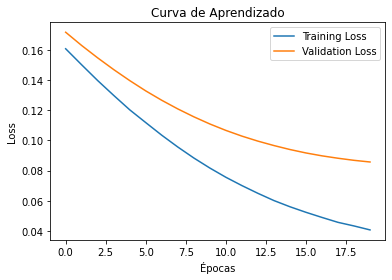

In [66]:
new_model.compile(optimizer='adam', loss='mean_squared_error')


history = new_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3)
new_model.save('modelo_seed42.h5')
# Plotar a curva de aprendizado
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
Data_Power[-10:]

114    0.997768
115    1.000000
116    0.953901
117    0.849090
118    0.429289
119    0.525505
120    0.851211
121    0.461882
122    0.510325
123    0.510325
Name: Daily Power yields (kWh), dtype: float64

In [68]:
Data_Power[-6:-3]

118    0.429289
119    0.525505
120    0.851211
Name: Daily Power yields (kWh), dtype: float64

In [69]:
previsoes = []

In [70]:
vetorlag_cego1 = Data_Power[-6:-3]

vetorlag_cego1 = np.array(vetorlag_cego1).reshape(1,-1)
print(vetorlag_cego1.shape)

# print("Entrada para ser previsto o próximo do test às cegas: \n")
# print(vetorlag_cego)
# print(vetorlag_cego.shape)

output_cego1_n = new_model.predict(vetorlag_cego1)
output_cego1 = scaler.inverse_transform(output_cego1_n)

previsoes.append(output_cego1[0].tolist())

rmse = np.array(((output_cego1[0] - Data_Power_desn[-3:-2])**2)**0.5)

print(f'Previsão: {output_cego1[0]} +/- {rmse}')
print(f"Era para prever: {Data_Power_desn[-3:-2].values}")

(1, 3)
1/1 [==============================] - 0s 52ms/step
Previsão: [856.9873] +/- [21.21269531]
Era para prever: [878.2]


In [71]:
print(previsoes)

[[856.9873046875]]


In [72]:
outputcego2 = pd.concat([Data_Power[-5:-3], pd.Series(output_cego1_n.flatten())])
print(outputcego2)

119    0.525505
120    0.851211
0      0.438204
dtype: float64


In [73]:
vetorlag_cego2 = np.array(outputcego2).reshape(1,-1)
output_cego2_n = new_model.predict(vetorlag_cego2)
output_cego2 = scaler.inverse_transform(output_cego2_n)

previsoes.append(output_cego2[0].tolist())


rmse2 = np.array(((output_cego2[0] - Data_Power_desn[-2:-1])**2)**0.5)

print(f'Previsão: {output_cego2[0]} +/- {rmse2}')
print(f"Era para prever: {Data_Power_desn[-2:-1].values}")

1/1 [==============================] - 0s 21ms/step
Previsão: [805.9153] +/- [115.6847168]
Era para prever: [921.6]


In [74]:
output_cego2[0].tolist()

[805.915283203125]

In [75]:
outputcego3 = pd.concat([Data_Power[-4:-3], pd.Series(output_cego1_n.flatten()), pd.Series(output_cego2_n.flatten())])
print(outputcego3)

120    0.851211
0      0.438204
0      0.381198
dtype: float64


In [76]:
vetorlag_cego3 = np.array(outputcego3).reshape(1,-1)
output_cego3_n = new_model.predict(vetorlag_cego3)
output_cego3 = scaler.inverse_transform(output_cego3_n)

previsoes.append(output_cego3[0].tolist())


rmse3 = np.array(((output_cego3[0] - Data_Power_desn[-1:])**2)**0.5)


print(f'Previsão: {output_cego3[0]} +/- {rmse3}')
print(f"Era para prever: {Data_Power_desn[-1:].values}")


1/1 [==============================] - 0s 22ms/step
Previsão: [916.6662] +/- [4.93380127]
Era para prever: [921.6]


In [77]:
previsoes = np.array(previsoes).flatten()
print(previsoes)

[856.98730469 805.9152832  916.66619873]


In [78]:
real = Data_Power_desn[-3:]
print(real)

real = real.to_list()

121    878.2
122    921.6
123    921.6
Name: Daily Power yields (kWh), dtype: float64


In [79]:
print(real)

[878.2, 921.6, 921.6]


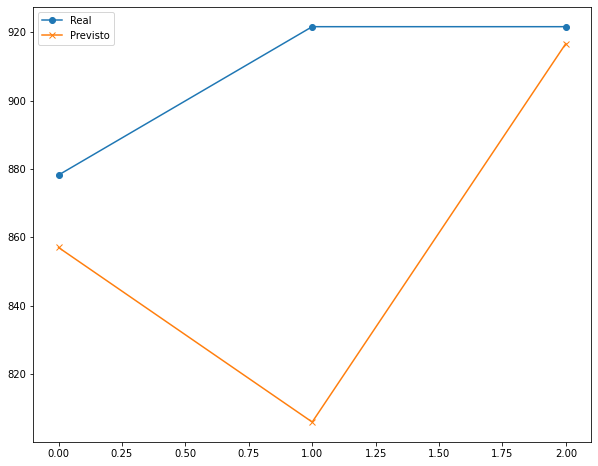

In [80]:
plt.figure(figsize=(10,8))
plt.plot(real, marker='o', label='Real')
plt.plot(previsoes, marker='x', label='Previsto')
plt.legend()
plt.show()

In [81]:

entrada_lista = [878.2, 921.6, 921.6]
entrada_lista = scaler.transform(np.array(entrada_lista).reshape(-1,1))
entrada_array = np.array([entrada_lista])
previsao = new_model.predict([entrada_array])


previsao_lista = scaler.inverse_transform(previsao).tolist()

print(f'Entrada: {entrada_lista}')
print(f'Previsão: {previsao_lista}')



1/1 [==============================] - 0s 46ms/step
Entrada: [[0.46188191]
 [0.51032481]
 [0.51032481]]
Previsão: [[791.0299682617188]]


In [82]:

entrada_lista = [878.2, 921.6, 921.6]
entrada_lista = scaler.transform(np.array(entrada_lista).reshape(-1,1))
entrada_array = np.array([entrada_lista])
previsao = new_model.predict([entrada_array])


previsao_lista = scaler.inverse_transform(previsao).tolist()

print(f'Entrada: {entrada_lista}')
print(f'Previsão: {previsao_lista}')



1/1 [==============================] - 0s 23ms/step
Entrada: [[0.46188191]
 [0.51032481]
 [0.51032481]]
Previsão: [[791.0299682617188]]


In [83]:
ultimo_valor_loss = history.history['loss'][-1]
# Salvar o último valor de loss em um arquivo
with open('ultimo_loss.txt', 'w') as file:
    file.write(str(ultimo_valor_loss))


In [84]:

with open('ultimo_loss.txt', 'r') as file:
    ultimo_loss_lido = float(file.read())

# Agora, você pode usar 'ultimo_loss_lido' no segundo código conforme necessário
print(f"Último valor de loss lido: {ultimo_loss_lido}")


Último valor de loss lido: 0.040635526180267334
